In [17]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from random import randrange


## Import Dataset & Data Preparation

In [18]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
print(train.head())

quants = np.zeros(11)
alphas = np.array(np.linspace(0,1,11))
for q in range(11):
    quants[q] = np.quantile(np.ravel(train.iloc[:,0:24].values), alphas[q] )


   Hour 01  Hour 02  Hour 03  Hour 04  Hour 05  Hour 06  Hour 07  Hour 08  \
0    24.31    24.31    21.71     8.42     0.01     0.01     0.02     0.01   
1    16.01    11.00     9.01     7.50     9.00     7.45    16.50    28.01   
2    28.00    24.50    24.15    18.99    15.50    23.11    29.01    39.73   
3    31.01    28.69    27.00    24.20    12.02    27.00    28.00    34.85   
4    22.00    19.50    17.55    15.91    11.40    22.65    27.30    34.00   

   Hour 09  Hour 10  ...  Hour 19  Hour 20  Hour 21  Hour 22  Hour 23  \
0     0.01     6.31  ...    37.99    33.11    37.99    33.00    36.48   
1    29.96    39.60  ...    59.69    50.09    50.00    36.22    31.09   
2    43.81    49.09  ...    60.99    55.51    51.77    34.51    39.31   
3    41.31    42.03  ...    58.99    53.50    44.01    35.00    34.46   
4    40.01    45.00  ...    53.00    45.91    36.74    29.61    30.61   

   Hour 24  month  day  year  day_of_week  
0    30.65      0    0  2007            0  
1    29.84

In [19]:
# price_bins = np.concatenate((np.array(range(0,100,11)),[3000]))
price_bins = quants
sums=train.iloc[:,0].value_counts(bins=price_bins)
for i in range(1,24):
    sums= sums+ train.iloc[:,i].value_counts(bins=price_bins)
print(sums)

(0.009000000000000001, 19.5]    2635
(19.5, 26.91]                   2631
(26.91, 32.16]                  2627
(32.16, 37.12]                  2631
(37.12, 43.0]                   2644
(43.0, 49.99]                   2616
(49.99, 59.941]                 2629
(59.941, 71.632]                2630
(71.632, 88.01]                 2631
(88.01, 2500.0]                 2630
dtype: int64


In [20]:

class CustomDiscreteActionSpace(spaces.Discrete):
    def __init__(self, start=-25, end=25, step=12.5):
        num_actions = int((end - start) / step) + 1
        super(CustomDiscreteActionSpace, self).__init__(num_actions)
        self.start = start
        self.step_size = step
        self.end = end
    def map_to_action(self, action_index):
        return self.start + action_index * self.step_size

custom_action_space = CustomDiscreteActionSpace()

## Define Environment

In [25]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, seed, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()
        
        # Set the seed for reproducibility
        self.seed_value = seed
        np.random.seed(self.seed_value)
        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = custom_action_space
        self.action_space_step = custom_action_space.step_size
        
        self.time_constraint = 6
        self.battery_time_constraint = 20 
        self.price_bins = np.array([-1,20,27,32,37,43,50,60,72,88,3000]) 
        self.initialize_params()
        
    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_battery = 20
        self.available = True
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price_binned = np.max(np.where(self.price_bins<self.current_price))
        self.current_state = tuple([ int(self.current_battery//10.001), self.current_price_binned, self.current_hour])
        self.state_space = [5, len(self.price_bins)-1, 24, self.action_space.n]
        self.done = False
        self.profit = 0 
        
    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5 
        else:
            available = True
        return available
    
    def update_state(self):
        self.old_price = self.price_data.iloc[self.current_step, self.current_hour]
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            self.current_hour = 17
            self.current_battery -= 20
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
        
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price_binned =  np.max(np.where(self.price_bins<self.current_price))
        
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        # Update time step and hour
        
        self.current_state = tuple([int(self.current_battery//10.001), self.current_price_binned, self.current_hour])
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
    def to_discrete(self, action): #accepts action index (from the q table) and returns an action with that index
        return int(self.action_space.start + action * self.action_space_step)

    def reward(self, action, charge_cost):
        reward = -charge_cost 
        return reward
        
    def step(self, action):
        self.available=self.car_available()

        #  discretize action
        if self.available == True:
            action = self.to_discrete(action) 
        else:
            action = 0
            
        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action* 2 
        charge_cost *= energy_rate / 1000
        
        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
        self.current_battery += actual_charge
        
        # update variables
        self.profit += -charge_cost

        # reward
        reward = self.reward(action, charge_cost)
        
        self.update_state()
        return self.current_state, reward, self.done, self.available

## Define QAgent

In [26]:
class QAgent():
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.1, epsilon=0.1):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 7 am constraint  
        if self.env.current_hour == self.env.time_constraint and self.env.current_battery >= self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)*0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.current_hour == self.env.time_constraint and self.env.current_battery < self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)/0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.current_battery)*0.9), -self.env.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
                
        # construct boolean mask_vector
        mask = np.arange(env.action_space.start, env.action_space.end + 1, env.action_space.step_size) 
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()

        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            
            action = np.random.choice(np.arange(self.env.action_space.n)[mask])
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        return action

    def train(self, simulations = 100, epsilon = 0.1):
        for i in range(simulations):
            while not self.env.done:    
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state) #these should be indices
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta   
            print(f'{i} simulations done')
            self.profit.append(env.profit)
            self.env.initialize_params()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action


    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')
        plt.ylabel('Profit')
        plt.title("Cost per epoch")

## Train QAgent

In [27]:
env = SmartGridEnv(train, seed = 2)
agent = QAgent(env)
agent.Qtable.shape
agent.train(simulations=40) 

0 simulations done
1 simulations done
2 simulations done
3 simulations done
4 simulations done
5 simulations done
6 simulations done
7 simulations done
8 simulations done
9 simulations done
10 simulations done
11 simulations done
12 simulations done
13 simulations done
14 simulations done
15 simulations done
16 simulations done
17 simulations done
18 simulations done
19 simulations done
20 simulations done
21 simulations done
22 simulations done
23 simulations done
24 simulations done
25 simulations done
26 simulations done
27 simulations done
28 simulations done
29 simulations done
30 simulations done
31 simulations done
32 simulations done
33 simulations done
34 simulations done
35 simulations done
36 simulations done
37 simulations done
38 simulations done
39 simulations done


In [28]:
print(agent.Qtable[:,8,18])

#agent.plot_profits()

[[ 0.          0.         -0.76559698 -1.96161599 -3.30379308]
 [ 0.          0.1447333  -0.36135213 -1.36049119 -2.89719961]
 [ 0.          0.45643712  0.2217583  -0.44765739 -1.24826735]
 [ 1.18097354  0.15226883  0.20809021 -0.28549629  0.        ]
 [ 0.          1.17405143  0.          0.          0.        ]]


## Eval QAgent

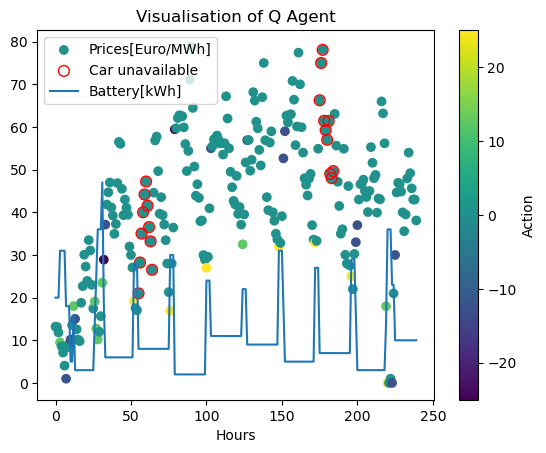

Profit on validation set: -427.78


In [38]:
eval_env = SmartGridEnv(val, seed = 2)
agent.env = eval_env

#storing values for visualisation
no_hours = val.shape[0]*24
actions = []
battery_charges = []
availables = []
hours = np.array(range(no_hours))
h=0
available=True

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action_index = agent.predict(current_state)
    action = agent.env.action_space.map_to_action(action_index)
    if available==False:
        battery_charges = battery_charges + list(agent.env.current_battery for i in range(10))
    next_state, reward, done, available = agent.env.step(action_index)
    availables.append(available)
    if available == True:
        actions.append(action)
        battery_charges.append(agent.env.current_battery)
        h=h+1
    if available == False:
        actions = actions + list(int(i) for i in np.zeros(10))
        availables = availables + list(available for i in range(9))
        h=h+10
    
no_days_plot=10


prices = []
[prices.extend(e) for e in val.iloc[0:no_days_plot, 0:24].values]
v=list(availables)

not_available = np.array([index for index, value in enumerate(v) if not value])
actions=np.array(actions)
battery_charges=np.array(battery_charges)
availables=np.array(availables)
hours= np.array(hours)
prices=np.array(prices)
rng= range(no_days_plot*24)


#plotting
f,ax = plt.subplots()
#plotting prices against hours
points = ax.scatter(hours[rng], prices[rng], c=actions[rng], label='Prices[Euro/MWh]')
f.colorbar(points, label='Action')
#add 'unavailable' points
plt.scatter(not_available[not_available<len(rng)],prices[not_available[not_available<len(rng)]], s=60,  marker='o', facecolors='none', edgecolors='r', label='Car unavailable')
plt.title('Visualisation of Q Agent')
plt.xlabel('Hours')
plt.plot(hours[rng], battery_charges[rng], label = 'Battery[kWh]')
plt.legend(loc="upper left")

plt.show()

print(f"Profit on validation set: {eval_env.profit:.2f}")
